In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Probably need to change this if your on MAC
spark = (
    SparkSession.builder.appName("Outlier")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '8g')
    .config('spark.executor.memory', '8g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/09/19 13:13:36 WARN Utils: Your hostname, Andy-PC resolves to a loopback address: 127.0.1.1; using 172.18.158.97 instead (on interface eth0)
24/09/19 13:13:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/19 13:13:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
full_transaction = spark.read.parquet("../data/curated/full_transactions")
full_transaction.show()

+--------------------+--------+--------------+------------+-------+-----------+-------------------+------------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+----------+
|            order_id|postcode|order_datetime|merchant_abn|user_id|consumer_id|       dollar_value|     consumer_name|state|     gender|consumer_fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|  Tot_M|  Tot_P|  Tot_F|order_time|
+--------------------+--------+--------------+------------+-------+-----------+-------------------+------------------+-----+-----------+--------------------------+--------------------+--------------------+-----

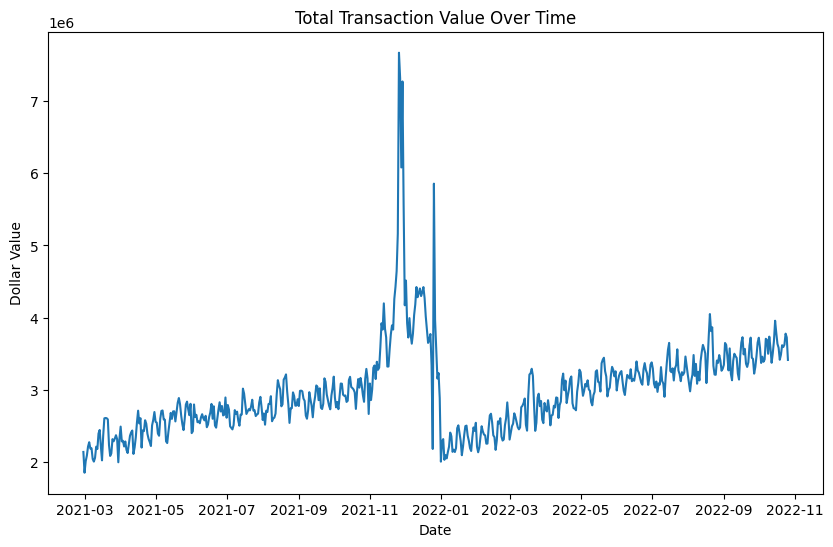

In [4]:
full_transaction_aggregated = full_transaction.groupBy("order_datetime").agg(F.sum("dollar_value").alias("total_value"))

df_pandas = full_transaction_aggregated.orderBy("order_datetime").toPandas()


plt.figure(figsize=(10, 6))

sns.lineplot(x="order_datetime", y="total_value", data=df_pandas)

plt.title("Total Transaction Value Over Time")
plt.xlabel("Date")
plt.ylabel("Dollar Value")
plt.show()



In [5]:
full_transaction.select("dollar_value").summary().show()

+-------+--------------------+
|summary|        dollar_value|
+-------+--------------------+
|  count|            11370450|
|   mean|   158.4431167469993|
| stddev|  461.26846497750705|
|    min|9.756658099412162E-8|
|    25%|  25.629291621509754|
|    50%|   60.91890120772714|
|    75%|  147.52347895720393|
|    max|  105193.88578925544|
+-------+--------------------+



In [6]:
print(full_transaction.stat.approxQuantile("dollar_value", [0.9999], 0))
full_transaction.approxQuantile("dollar_Value", [0.9999], 0.0001)[0]

[17075.666208546078]


105193.88578925544

In [7]:
print(full_transaction.stat.approxQuantile("dollar_value", [0.9999], 0))
full_transaction.approxQuantile("dollar_Value", [0.9999], 0.0001)[0]

[17075.666208546078]


105193.88578925544

+-------+--------------------+
|summary|        dollar_value|
+-------+--------------------+
|  count|            11366639|
|   mean|  153.21228053814542|
| stddev|  335.04013303606314|
|    min|9.756658099412162E-8|
|    25%|  25.621619018818144|
|    50%|   60.89088912601436|
|    75%|  147.36851050706778|
|    max|   8695.158809014565|
+-------+--------------------+



Text(0, 0.5, 'Density')

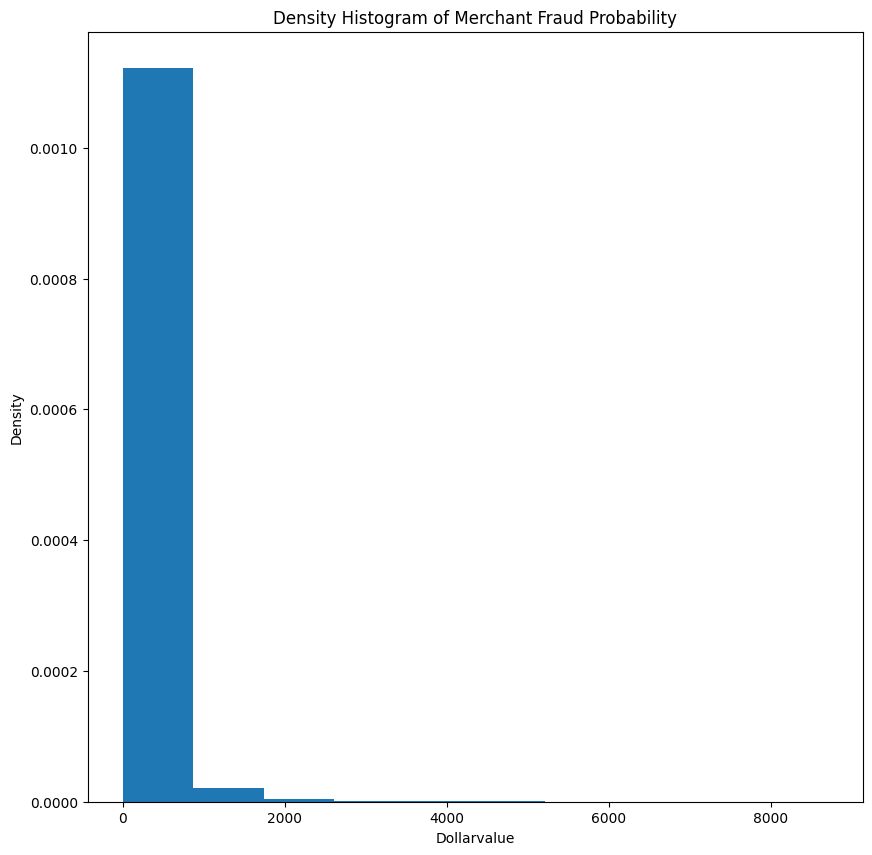

In [8]:
full_transaction = full_transaction.filter((F.col("dollar_value")<=(full_transaction.approxQuantile("dollar_value", [0.9997], 0.0001))[0]))
full_transaction.select("dollar_value").summary().show()
fraud = list(full_transaction.select("dollar_value").toPandas()["dollar_value"])
plt.figure(figsize=(10,10))
plt.hist(fraud, density = True)
plt.title('Density Histogram of Merchant Fraud Probability')
plt.xlabel('Dollarvalue')
plt.ylabel('Density')

In [9]:
full_transaction_aggregated.orderBy(F.desc("total_value")).limit(20)

order_datetime,total_value
2021-11-26,7671867.712207416
2021-11-27,7319835.19042584
2021-11-29,7273349.707119821
2021-11-28,6080658.700525394
2021-12-26,5856210.174406209
2021-11-30,5557043.316822094
2021-11-25,5164603.682063344
2021-11-24,4644093.157307881
2021-12-02,4512769.767886083
2021-11-23,4424741.080677749


In [10]:
full_transaction = full_transaction.filter((F.col("order_datetime") != "2021-11-26") &
                                           (F.col("order_datetime") != "2021-11-27") &
                                           (F.col("order_datetime") != "2021-11-29") &
                                           (F.col("order_datetime") != "2021-11-28") &
                                           (F.col("order_datetime") != "2021-12-26") &
                                           (F.col("order_datetime") != "2021-11-30") &
                                           (F.col("order_datetime") != "2021-11-25"))

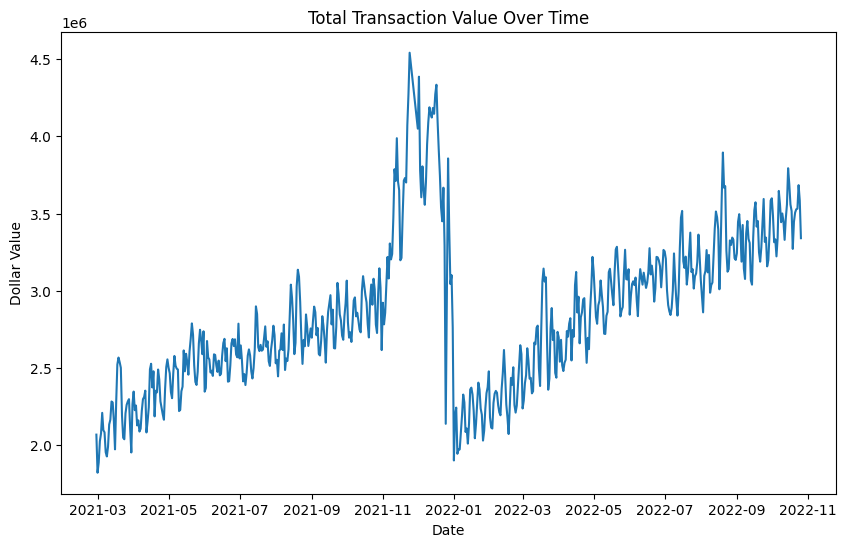

In [11]:
full_transaction_aggregated = full_transaction.groupBy("order_datetime").agg(F.sum("dollar_value").alias("total_value"))
df_pandas = full_transaction_aggregated.orderBy("order_datetime").toPandas()

plt.figure(figsize=(10, 6))

sns.lineplot(x="order_datetime", y="total_value", data=df_pandas)

plt.title("Total Transaction Value Over Time")
plt.xlabel("Date")
plt.ylabel("Dollar Value")
plt.show()

+-------+------------------+
|summary|Median_age_persons|
+-------+------------------+
|  count|          11085163|
|   mean|43.416857108912154|
| stddev| 7.459837475934776|
|    min|               0.0|
|    25%|              38.0|
|    50%|              43.0|
|    75%|              48.0|
|    max|              79.0|
+-------+------------------+



Text(0, 0.5, 'Density')

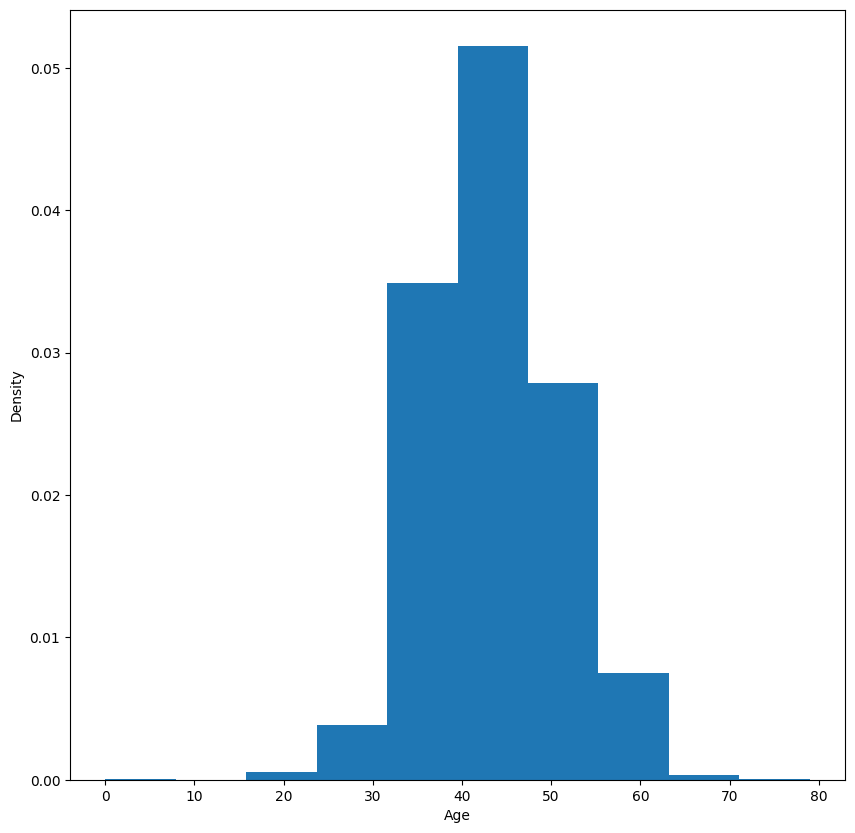

In [12]:
full_transaction.select("Median_age_persons").summary().show()
age = list(full_transaction.select("Median_age_persons").toPandas()["Median_age_persons"])
plt.figure(figsize=(10,10))
plt.hist(age, density = True)
plt.xlabel('Age')
plt.ylabel('Density')

+-------+-------------------------+
|summary|Median_tot_fam_inc_weekly|
+-------+-------------------------+
|  count|                 11085163|
|   mean|        1976.033149174261|
| stddev|         650.498345542098|
|    min|                      0.0|
|    25%|                   1526.0|
|    50%|                   1875.0|
|    75%|                   2268.0|
|    max|                   7000.0|
+-------+-------------------------+



Text(0, 0.5, 'Density')

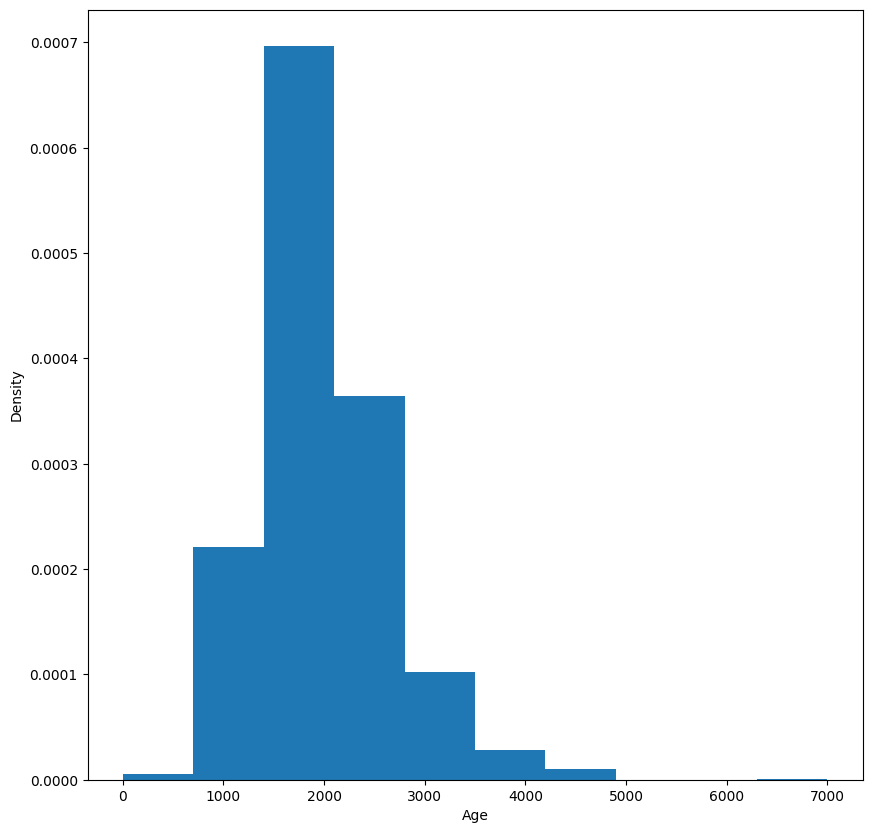

In [13]:
full_transaction.select("Median_tot_fam_inc_weekly").summary().show()
family_income = list(full_transaction.select("Median_tot_fam_inc_weekly").toPandas()["Median_tot_fam_inc_weekly"])
plt.figure(figsize=(10,10))
plt.hist(family_income, density = True)
plt.xlabel('Age')
plt.ylabel('Density')

+-------+-------------------------+
|summary|Median_tot_hhd_inc_weekly|
+-------+-------------------------+
|  count|                 11085163|
|   mean|       1605.3427244146071|
| stddev|        536.8386302800888|
|    min|                      0.0|
|    25%|                   1213.0|
|    50%|                   1486.0|
|    75%|                   1942.0|
|    max|                   4184.0|
+-------+-------------------------+



Text(0, 0.5, 'Density')

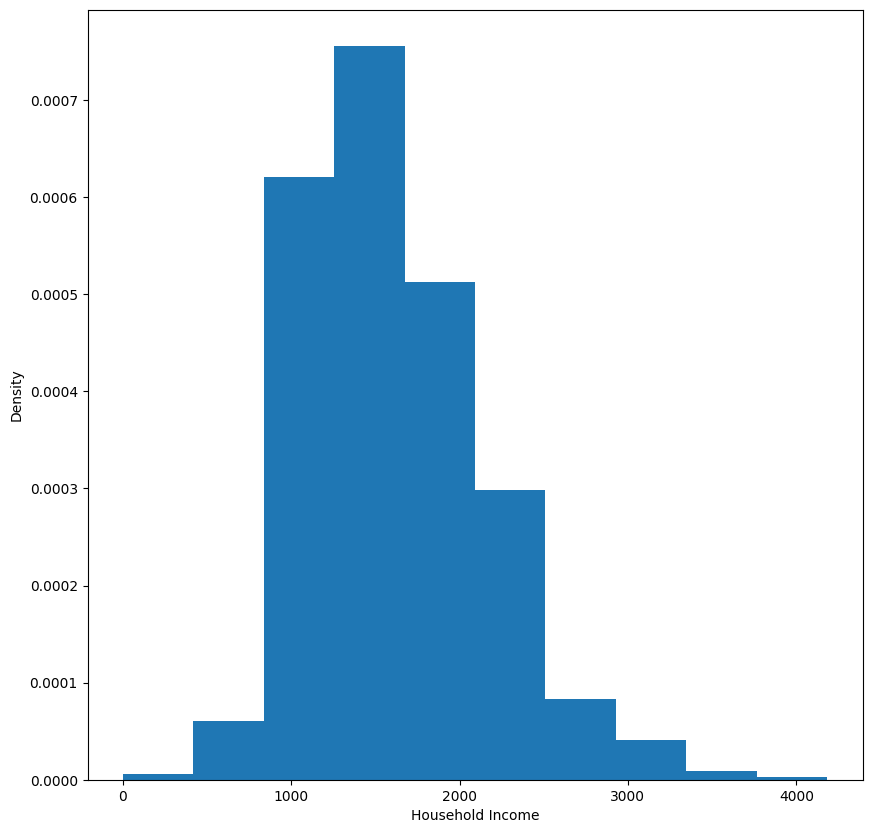

In [14]:
full_transaction.select("Median_tot_hhd_inc_weekly").summary().show()
household_income = list(full_transaction.select("Median_tot_hhd_inc_weekly").toPandas()["Median_tot_hhd_inc_weekly"])
plt.figure(figsize=(10,10))
plt.hist(household_income, density = True)
plt.xlabel('Household Income')
plt.ylabel('Density')

+-------+----------------------+
|summary|Average_household_size|
+-------+----------------------+
|  count|              11085163|
|   mean|    2.4579101362784614|
| stddev|    0.3479622192673847|
|    min|                   0.0|
|    25%|                   2.3|
|    50%|                   2.4|
|    75%|                   2.7|
|    max|                   4.2|
+-------+----------------------+



Text(0, 0.5, 'Density')

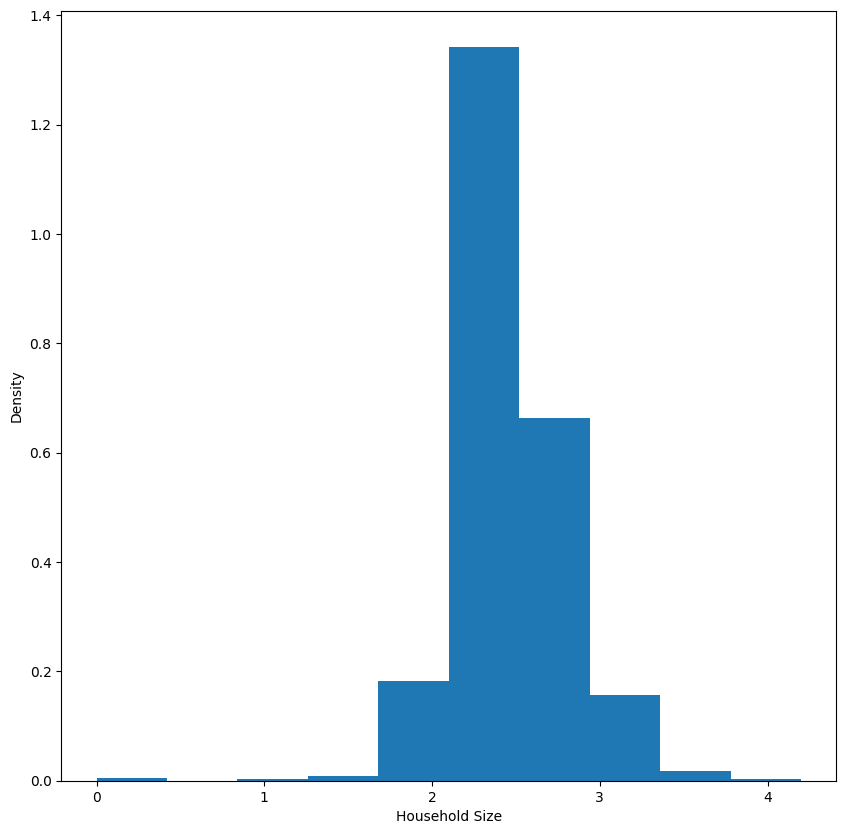

In [15]:
full_transaction.select("Average_household_size").summary().show()
household_size = list(full_transaction.select("Average_household_size").toPandas()["Average_household_size"])
plt.figure(figsize=(10,10))
plt.hist(household_size, density = True)
plt.xlabel('Household Size')
plt.ylabel('Density')

In [16]:
full_transaction.select("Tot_M").summary().show()

+-------+-----------------+
|summary|            Tot_M|
+-------+-----------------+
|  count|         11085163|
|   mean|4760.650789257677|
| stddev|6872.799822570006|
|    min|              0.0|
|    25%|            360.0|
|    50%|           1747.0|
|    75%|           6863.0|
|    max|          66596.0|
+-------+-----------------+



In [17]:
full_transaction.select("Tot_F").summary().show()

+-------+------------------+
|summary|             Tot_F|
+-------+------------------+
|  count|          11085163|
|   mean| 4886.226016523167|
| stddev|7086.3601240878315|
|    min|               0.0|
|    25%|             325.0|
|    50%|            1732.0|
|    75%|            7084.0|
|    max|           63291.0|
+-------+------------------+



In [18]:
full_transaction.select("Tot_P").summary().show()

+-------+-----------------+
|summary|            Tot_P|
+-------+-----------------+
|  count|         11085163|
|   mean|9646.859806662293|
| stddev|13953.16227848443|
|    min|              0.0|
|    25%|            688.0|
|    50%|           3484.0|
|    75%|          13959.0|
|    max|         129888.0|
+-------+-----------------+



+-------+-----------------+
|summary|            tags3|
+-------+-----------------+
|  count|         11085163|
|   mean|4.589056095073365|
| stddev|1.738762458376754|
|    min|              0.1|
|    25%|             3.05|
|    50%|             4.78|
|    75%|             6.16|
|    max|              7.0|
+-------+-----------------+



Text(0, 0.5, 'Density')

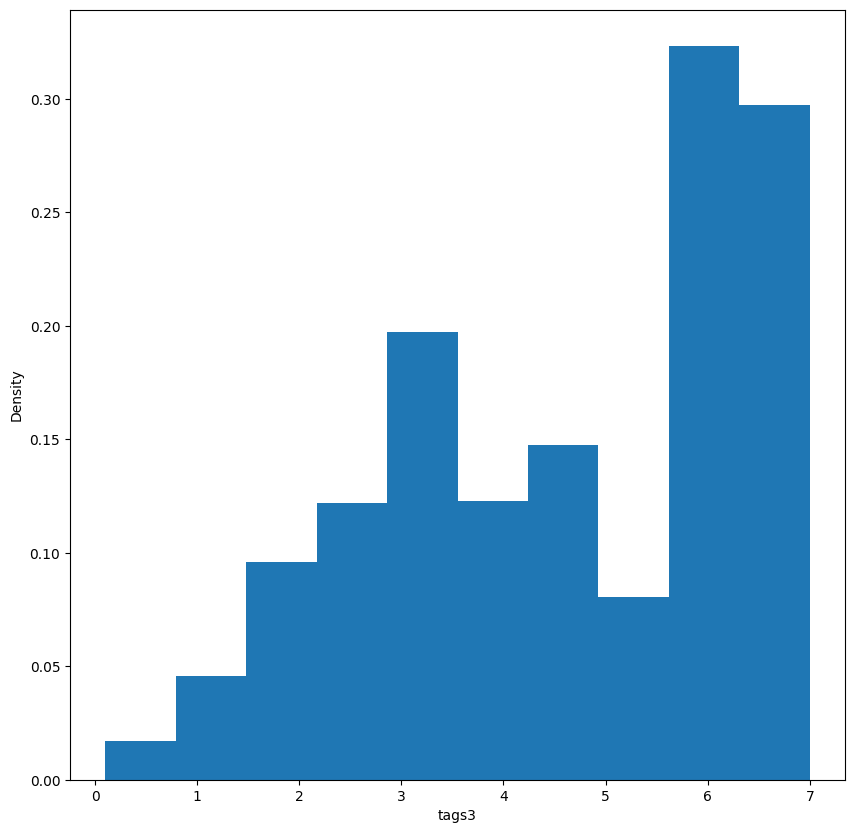

In [19]:
full_transaction.select("tags3").summary().show()
tags3 = list(full_transaction.select("tags3").toPandas()["tags3"])
plt.figure(figsize=(10,10))
plt.hist(tags3, density = True)
plt.xlabel('tags3')
plt.ylabel('Density')

In [20]:
full_transaction.select("consumer_fraud_probability").summary().show()

+-------+--------------------------+
|summary|consumer_fraud_probability|
+-------+--------------------------+
|  count|                  11085163|
|   mean|        13.176343716009205|
| stddev|        1.2592391204348414|
|    min|         8.287143531552802|
|    25%|        12.289497257049973|
|    50%|        13.176941888464626|
|    75%|        14.061375870783095|
|    max|          97.6298077657765|
+-------+--------------------------+



In [21]:
full_transaction.select("merchant_fraud_probability").summary().show()

+-------+--------------------------+
|summary|merchant_fraud_probability|
+-------+--------------------------+
|  count|                  11085163|
|   mean|        27.591712351347514|
| stddev|        11.476973050553013|
|    min|         5.272028210752524|
|    25%|         17.78091686193875|
|    50%|        27.464811652771004|
|    75%|         36.29712800115408|
|    max|         86.51262037888318|
+-------+--------------------------+



In [22]:
high_risk_transactions = full_transaction.filter((F.col("merchant_fraud_probability") > 70) & 
                                   (F.col("dollar_value") > 5000))

high_risk_transactions.show(100)

+--------------------+--------+--------------+------------+-------+-----------+------------------+--------------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+----------+
|            order_id|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|       consumer_name|state|     gender|consumer_fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|  Tot_M|  Tot_P|  Tot_F|order_time|
+--------------------+--------+--------------+------------+-------+-----------+------------------+--------------------+-----+-----------+--------------------------+--------------------+--------------------+--

In [23]:

high_risk_transactions = full_transaction.filter((F.col("consumer_fraud_probability") > 70) & 
                                   (F.col("dollar_value") > 1000))

high_risk_transactions.show(100, truncate=False)

+------------------------------------+--------+--------------+------------+-------+-----------+-----------------+--------------------+-----+------+--------------------------+-------------------------+-------------------------------------------------------------------------------------+-----------------------------------------------------------+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+----------+
|order_id                            |postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value     |consumer_name       |state|gender|consumer_fraud_probability|merchant_name            |tags                                                                                 |tags1                                                      |tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M 

In [24]:
full_transaction.filter(F.col("Median_tot_fam_inc_weekly") == 7000).show()

+--------------------+--------+--------------+------------+-------+-----------+------------------+---------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+----------+
|            order_id|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|  consumer_name|state|     gender|consumer_fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M|Tot_P|Tot_F|order_time|
+--------------------+--------+--------------+------------+-------+-----------+------------------+---------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+--